# Pipeline Test

Testing each step of my pipeline.

## Rough Outline (Jul. 7, 2025)
1. Grab playlist data from Spotify API.
   * The information available from the Spotify API should be enough. Features such as the number of releases, popularity, etc.
   * Later, in the UI itself, I would like the option to select a playlist instead of solely using a predefined one. This would then require the ability to automatically grab the playlist's most up-to-date features at any given moment. 
   * Note: I don't think I need features such as subgenres and audio features, as I believe those are likely already taken into account by lastfm in their recommendations to some extent. However, if needed, someone made an Exportify CLI (I have yet to try it) that may be useful here. It's just that as far as I'm concerned, I don't think it would do me any good to have those features if I cannot get those features for the similar artists. Also, Exportify yields song-level data.
2. Generate relevant features using Spotify API.
   * These (remember, artist-level) features would be things like: 
     * popularity (not sure how this is computed; I wonder if it would be better estimated via the total number of streams, although that would require more API requests and slow down the pipeline; lastfm has artist total playcounts that I can use instead)
     * number of releases
     * year of first release
     * year of last release
     * number of albums
     * number of tracks
     * number of times they show up in playlist (as primary artist or as a feature)
     * artist picture (for UI visualization purposes but obviously not a feature)
3. Generate relevant features using Lastfm API.
   * From `artist.getInfo` endpoint - things like: 
     * total listeners
     * total playcount
     * number of MY streams 
     * tags (genre tags; may or may not use; if I do use though, would need some way of filtering out irrelevant tags)
     * description/summary: for visualization purposes but also allows me to mine for nationality (+ record label, history, etc.) using some NLP technique if I'd like to use it as a feature or visualization tag
     * on tour: lastfm has a binary `ontour` label for each artist, although I think I want more detailed tour info, e.g., starting tour soon. 
4. Grab similar artists using Lastfm API.
   * In the final UI, I want to be able to toggle how many ripples outwards to go. Start with just one though; that would also be the ripple that contains the most immediate artists I should look into as they are deemed most similar to the ones I already like.
5. Grab touring data from external API - Songkick or Bandsintown.
6. Compute similarity/prioritization score using features and weights (GNN implementation).
   * Make sure that similar artists who are already in the playlist are not considered in the score. Or actually, would it make sense to weigh similar artists of those artists more heavily? That might make more sense actually.
   * Take into account the features listed in steps 2 and 3. Compute specific weights accordingly (proportion of artist songs in playlist, e.g.)
   * Generate rankings (top 5 or 10 highest similarity scorers)
7. Build UI. 
   * I want to have a means of visualizing the knowledge graph. I want to be able to select a node (an artist) and see their profile (basic info, their image, some of their general features)
   * I want the recommendations to have explainability - what features contributed to their being recommended?
   * Filtering options: 
      * Number of similar artist ripples outward
      * Minimum number of tracks an artist has in the playlist in order to be considered
      * Minimum number of my streams on that artist (^)
      * Which features to consider in the recommendations
    * I also want the ability to just directly select artists (2 or more) to generate the knowledge graph and recommendations for.
    * I would prefer not to use streamlit; I'm a bit tired of it and would prefer some novelty. I'm also not sure what frameworks even allow for visualization of knowledge graphs. I presume the KG can be produced in Plotly.
      * [Gradio](https://www.gradio.app/)
      * I want something similar to [this](https://huggingface.co/spaces/emilyalsentzer/SHEPHERD)
8. **Grab social media data; further prioritize artists commonly mentioned or recommended by social media accounts. This is a difficult thing to figure out and I will try it after I've finished everything else.

In [170]:
import pandas as pd
import numpy as np
import json
import spotipy
import re
import requests
import os
import string
import matplotlib.pyplot as plt
from string import punctuation
from datetime import datetime, timedelta
from dotenv import load_dotenv
from collections import Counter
from spotipy.oauth2 import SpotifyClientCredentials
load_dotenv()

True

### Step 1 - Grab playlist data from Spotify API.
* The information available from the Spotify API should be enough. Features such as the number of releases, popularity, etc.
* Later, in the UI itself, I would like the option to select a playlist instead of solely using a predefined one. This would then require the ability to automatically grab the playlist's most up-to-date features at any given moment.
* Note: I don't think I need features such as subgenres and audio features, as I believe those are likely already taken into account by lastfm in their recommendations to some extent. However, if needed, someone made an Exportify CLI (I have yet to try it) that may be useful here. It's just that as far as I'm concerned, I don't think it would do me any good to have those features if I cannot get those features for the similar artists. Also, Exportify yields song-level data.

--

Note that in the final UI, it would be nice to implement Spotify Oauth in order to fetch all of a user's (my) playlists. However it's not absoutely necessary; I could just provide the link to the playlist.

In [16]:
SPOTIFY_CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
SPOTIFY_CLIENT_SECRET = os.environ.get("SPOTIFY_CLIENT_SECRET")

auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID,
                                        client_secret=SPOTIFY_CLIENT_SECRET)
SPOTIFY = spotipy.Spotify(auth_manager=auth_manager)

In [26]:
def get_playlist_artists(playlist_url, client=SPOTIFY): 

    """Returns artist information associated with each track in the provided playlist.
       Note that each artist may appear multiple times."""    

    response = client.playlist_tracks(playlist_url, offset=0)
    # each artist involved in a song with features is considered individually
    artists = [artist_dict for track in response["items"] for artist_dict in track["track"]["artists"]]
    # total number of tracks on playlist - needed to determine the number of loops (max tracks per req. is 100)
    total = response["total"]

    for offset in range(100, total + 1, 100): 

        response = client.playlist_tracks(playlist_url, offset=offset)
        artists += [artist_dict for track in response["items"] for artist_dict in track["track"]["artists"]]

    return artists

In [25]:
artist_dicts = get_playlist_artists("https://open.spotify.com/playlist/142oZDOc1za2dkUwyonA1P?si=f651169be5044b4d", 
                                    SPOTIFY)
artist_dicts[:5]

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artists/3Ri4H12KFyu98LMjSoij5V',
  'id': '3Ri4H12KFyu98LMjSoij5V',
  'name': 'Bad Omens',
  'type': 'artist',
  'uri': 'spotify:artist:3Ri4H12KFyu98LMjSoij5V'},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/3Ri4H12KFyu98LMjSoij5V'},
  'href': 'https://api.spotify.com/v1/artis

### Step 2 - Generate relevant features using Spotify API.
* These (remember, artist-level) features would be things like: 
     * popularity (not sure how this is computed; I wonder if it would be better estimated via the total number of streams, although that would require more API requests and slow down the pipeline; lastfm has artist total playcounts that I can use instead)
     * number of releases
     * year of first release
     * year of last release
     * number of albums
     * number of tracks
     * number of times they show up in playlist (as primary artist or as a feature)
     * artist picture (for UI visualization purposes but obviously not a feature)

In [75]:
def get_artist_info(artist_dicts, client=SPOTIFY):

    """Returns Spotify API information associated with each unique artist, as 
       well as the artist count in the playlist. A consolidation, essentially."""

    artist_uris = set([artist["uri"] for artist in artist_dicts])
    all_artist_info = []

    for uri in artist_uris: 

        artist_info = client.artist(uri)
        artist_count = sum([1 for artist_dict in artist_dicts if artist_dict["uri"] == uri])
        artist_info["playlist_count"] = artist_count

        # album info
        albums = client.artist_albums(uri, include_groups="album")
        # number of albums
        artist_info["albums"] = albums["total"]
        album_items = albums["items"]
        # doesn't account for singles outside albums
        # don't want to count an album twice if a deluxe version was released
        # note that live versions are counted for now
        tracks_count = 0
        for album in album_items: 
             tracks_count += album["total_tracks"]
        artist_info["tracks"] = tracks_count
        
        artist_info["last_album_date"] = album_items[0]["release_date"] if album_items else None
        artist_info["first_album_date"] = album_items[-1]["release_date"] if album_items else None
    
        all_artist_info.append(artist_info)

    return all_artist_info

In [76]:
artist_info = get_artist_info(artist_dicts)
artist_info

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4eMCK8Y88T54ZqWYnU51r5'},
  'followers': {'href': None, 'total': 104},
  'genres': [],
  'href': 'https://api.spotify.com/v1/artists/4eMCK8Y88T54ZqWYnU51r5',
  'id': '4eMCK8Y88T54ZqWYnU51r5',
  'images': [],
  'name': 'Bryan Kuznitz',
  'popularity': 27,
  'type': 'artist',
  'uri': 'spotify:artist:4eMCK8Y88T54ZqWYnU51r5',
  'playlist_count': 1,
  'albums': 0,
  'tracks': 0,
  'last_album_date': None,
  'first_album_date': None},
 {'external_urls': {'spotify': 'https://open.spotify.com/artist/4ZgQDCtRqZlhLswVS6MHN4'},
  'followers': {'href': None, 'total': 1206354},
  'genres': [],
  'href': 'https://api.spotify.com/v1/artists/4ZgQDCtRqZlhLswVS6MHN4',
  'id': '4ZgQDCtRqZlhLswVS6MHN4',
  'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb1e5c7968999985162cad7042',
    'height': 640,
    'width': 640},
   {'url': 'https://i.scdn.co/image/ab676161000051741e5c7968999985162cad7042',
    'height': 320,
    'width': 320}

In [77]:
def get_spotify_features(artist_info, client=SPOTIFY):

    """Generates and returns features for each artist."""

    features = []

    for artist_dict in artist_info: 

        features.append({
            "name": artist_dict["name"],
            "uri": artist_dict["uri"],
            "genres": artist_dict["genres"],
            "albums": artist_dict["albums"],
            'tracks': artist_dict["tracks"],
            'last_album_date': artist_dict["last_album_date"],
            'first_album_date': artist_dict["first_album_date"],
            "popularity": artist_dict["popularity"],
            "followers": artist_dict["followers"]["total"],
            "playlist_count": artist_dict["playlist_count"],
            "spotify_url": artist_dict["external_urls"]["spotify"],
            "image_320": artist_dict["images"][1]["url"] if artist_dict["images"] else []
        })

    return features

In [78]:
spotify_features = get_spotify_features(artist_info)
spotify_features

[{'name': 'Bryan Kuznitz',
  'uri': 'spotify:artist:4eMCK8Y88T54ZqWYnU51r5',
  'genres': [],
  'albums': 0,
  'tracks': 0,
  'last_album_date': None,
  'first_album_date': None,
  'popularity': 27,
  'followers': 104,
  'playlist_count': 1,
  'spotify_url': 'https://open.spotify.com/artist/4eMCK8Y88T54ZqWYnU51r5',
  'image_320': []},
 {'name': 'grandson',
  'uri': 'spotify:artist:4ZgQDCtRqZlhLswVS6MHN4',
  'genres': [],
  'albums': 2,
  'tracks': 24,
  'last_album_date': '2023-05-05',
  'first_album_date': '2020-12-04',
  'popularity': 66,
  'followers': 1206354,
  'playlist_count': 6,
  'spotify_url': 'https://open.spotify.com/artist/4ZgQDCtRqZlhLswVS6MHN4',
  'image_320': 'https://i.scdn.co/image/ab676161000051741e5c7968999985162cad7042'},
 {'name': 'Noah Sebastian',
  'uri': 'spotify:artist:3w0i7biKO0q6DGVXCKzhj9',
  'genres': [],
  'albums': 0,
  'tracks': 0,
  'last_album_date': None,
  'first_album_date': None,
  'popularity': 33,
  'followers': 1314,
  'playlist_count': 1,
  'sp

In [80]:
spotify_features_df = pd.DataFrame(spotify_features)
spotify_features_df

,name,uri,genres,albums,tracks,last_album_date,first_album_date,popularity,followers,playlist_count,spotify_url,image_320
0,Bryan Kuznitz,spotify:artist:4eMCK8Y88T54ZqWYnU51r5,[],0,0,None,None,27,104,1,https://open.spotify.com/artist/4eMCK8Y88T54Zq...,[]
1,grandson,spotify:artist:4ZgQDCtRqZlhLswVS6MHN4,[],2,24,2023-05-05,2020-12-04,66,1206354,6,https://open.spotify.com/artist/4ZgQDCtRqZlhLs...,https://i.scdn.co/image/ab676161000051741e5c79...
2,Noah Sebastian,spotify:artist:3w0i7biKO0q6DGVXCKzhj9,[],0,0,None,None,33,1314,1,https://open.spotify.com/artist/3w0i7biKO0q6DG...,[]
3,Thornhill,spotify:artist:2dE5audbkV3o5cKxvM7lBD,"[metalcore, djent]",5,59,2025-04-04,2019-10-25,57,162050,10,https://open.spotify.com/artist/2dE5audbkV3o5c...,https://i.scdn.co/image/ab676161000051741b292d...
4,Lil West,spotify:artist:59dLTffLsw2ljmCiD8O1JX,[],3,25,2023-04-14,2019-03-15,41,24186,1,https://open.spotify.com/artist/59dLTffLsw2ljm...,https://i.scdn.co/image/ab676161000051746bebe7...
...,...,...,...,...,...,...,...,...,...,...,...,...
74,Fame on Fire,spotify:artist:10Z7WzKMeIdNBKexi1YarP,[],4,57,2024-09-06,2020-09-04,57,329660,1,https://open.spotify.com/artist/10Z7WzKMeIdNBK...,https://i.scdn.co/image/ab67616100005174f41b86...
75,Holding Absence,spotify:artist:2tl280wIokrLjabzrSKTgU,"[metalcore, post-hardcore, melodic hardcore]",4,51,2023-08-25,2019-03-01,57,171531,2,https://open.spotify.com/artist/2tl280wIokrLja...,https://i.scdn.co/image/ab67616100005174787bfd...
76,Amira Elfeky,spotify:artist:6Z4kwq0LOaYQW2CqudoOIk,[shoegaze],0,0,None,None,60,186217,2,https://open.spotify.com/artist/6Z4kwq0LOaYQW2...,https://i.scdn.co/image/ab67616100005174fa864e...
77,Caskets,spotify:artist:2XIbOWDT5vZPW7jNyzdfcK,"[metalcore, post-hardcore]",2,21,2023-08-11,2021-08-13,61,211293,6,https://open.spotify.com/artist/2XIbOWDT5vZPW7...,https://i.scdn.co/image/ab67616100005174d1f782...


In [81]:
spotify_features_df[spotify_features_df['name'] == "Bad Omens"]

,name,uri,genres,albums,tracks,last_album_date,first_album_date,popularity,followers,playlist_count,spotify_url,image_320
54,Bad Omens,spotify:artist:3Ri4H12KFyu98LMjSoij5V,[metalcore],6,83,2024-05-31,2016-08-19,75,1776694,48,https://open.spotify.com/artist/3Ri4H12KFyu98L...,https://i.scdn.co/image/ab676161000051743a62c7...


#### A couple notes for steps 1-2: 
* The specific genres are actually still intact - these are the same genres that Exportify yields. So I can actually still use these genres in my recommendations if I want.
* The album and track count for each artist do not take into account non-album singles and EPs. It gets a little messy if I try to count those, bc I can't really distinguish non-album vs album singles (efficiently).
* The album and track count will double count in the case of live or deluxe albums. Again, I don't see an efficient way to get rid of those. Of course I could filter out albums containing "deluxe" or "live" but that will remove albums who genuinely use those words in their title. I just don't think it's a big enough deal to address.
* <mark>The whole Spotify API pipeline is a little slow. Find some way to speed it up in actual implementation (consider parallelizing)</mark>

--
### Step 3 - Generate relevant features using Lastfm API.
* From `artist.getInfo` endpoint - things like: 
 * total listeners
 * total playcount
 * number of MY streams 
 * tags (genre tags; may or may not use; if I do use though, would need some way of filtering out irrelevant tags)
 * description/summary: for visualization purposes but also allows me to mine for nationality (+ record label, history, etc.) using some NLP technique if I'd like to use it as a feature or visualization tag
 * on tour: lastfm has a binary `ontour` label for each artist, although I think I want more detailed tour info, e.g., starting tour soon. 

In [83]:
LASTFM_API_KEY = os.environ.get("LASTFM_API_KEY")

In [98]:
artist = "bad+omens"
url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist}&username={username}&api_key={LASTFM_API_KEY}&format=json"
response = requests.get(url)
omens = response.json()

In [104]:
artist = "dquwhdihsiuadiwjfoiwq"
username = "jasminexx18"
url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist}&username={username}&api_key={LASTFM_API_KEY}&format=json"
response = requests.get(url)
response.json()

{'error': 6,
 'message': 'The artist you supplied could not be found',
 'links': []}

In [108]:
# if nothing is found, just ignore (too much work to get MBIDs and try again, esp. given
# that Lastfm's MBIDs are sparsely populated
def get_lastfm_features(artist_names, username="jasminexx18", api_key=LASTFM_API_KEY): 

    """Grabs Lastfm features for a list of artists. Goes by artist name."""

    artist_info = []
    
    for artist_name in artist_names: 

        url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist_name}&username={username}&api_key={api_key}&format=json"

        try: 
            response = requests.get(url).json()["artist"]
            
            artist_info.append({
                "name": artist_name,
                "lastfm_listeners": response["stats"]["listeners"],
                "lastfm_playcount": response["stats"]["playcount"],
                "personal_playcount": response["stats"]["userplaycount"],
                "lastfm_tags": [tag["name"] for tag in response["tags"]["tag"]] if response["tags"]["tag"] else [],
                "summary": response["bio"]["summary"]
            })

        except Exception as e: 
            print(f"Artist {artist_name} not found on lastfm.")

    return artist_info

In [107]:
lastfm_features = get_lastfm_features(spotify_features_df["name"])
lastfm_features

[{'name': 'Bryan Kuznitz',
  'lastfm_listeners': '3',
  'lastfm_playcount': '6',
  'personal_playcount': '0',
  'lastfm_tags': [],
  'summary': ' <a href="https://www.last.fm/music/Bryan+Kuznitz">Read more on Last.fm</a>'},
 {'name': 'grandson',
  'lastfm_listeners': '715458',
  'lastfm_playcount': '20897336',
  'personal_playcount': '62',
  'lastfm_tags': ['indie rock',
   'alternative rock',
   'alternative',
   'seen live',
   'trap'],
  'summary': 'Grandson is an alternative artist hailing from Toronto, Canada. Born in the small town of Englewood New Jersey, he relocated to the cultural melting pot of Toronto at a young age, and grew up surrounded by music ranging from jazz to rock and roll to rap, dancehall and r&b. He began playing guitar and piano in high school.\n\nAt 17, he relocated to Montreal, QC to attend university, and began working in nightclubs cleaning tables and DJing. He started writing music at this time, incorporating the unique blend of sounds he grew up surround

In [109]:
lastfm_features_df = pd.DataFrame(lastfm_features)
lastfm_features_df

,name,lastfm_listeners,lastfm_playcount,personal_playcount,lastfm_tags,summary
0,Bryan Kuznitz,3,6,0,[],"<a href=""https://www.last.fm/music/Bryan+Kuzn..."
1,grandson,715458,20897336,62,"[indie rock, alternative rock, alternative, se...",Grandson is an alternative artist hailing from...
2,Noah Sebastian,28,217,0,[],"Noah Sebastian Davis (born October 31, 1995 in..."
3,Thornhill,160864,10548682,425,"[metalcore, alternative metal, Progressive Met...",After the band – comprising of Jacob Charlton ...
4,Lil West,41233,402891,0,"[Hip-Hop, rap, emo, underground hip-hop, trap]",22 year old Delaware rapper Lil West is an art...
...,...,...,...,...,...,...
74,Fame on Fire,175893,3957971,1,"[post-hardcore, alternative rock, metalcore, r...",Formed in 2013 in the theme park capital of th...
75,Holding Absence,214847,8165498,13,"[post-hardcore, seen live, alternative rock, e...","Holding Absence is a rock band from Cardiff, W..."
76,Amira Elfeky,205251,3774758,22,"[Nu Metal, rock, alternative metal, female voc...",Amira Lynne Elfeky is an American-Egyptian sin...
77,Caskets,234222,6909495,164,"[post-hardcore, metalcore, alternative rock, s...","Caskets, formed in 2018 under the name Captive..."


In [110]:
all_features = spotify_features_df.merge(lastfm_features_df, how="left", on="name")
all_features

,name,uri,genres,albums,tracks,last_album_date,first_album_date,popularity,followers,playlist_count,spotify_url,image_320,lastfm_listeners,lastfm_playcount,personal_playcount,lastfm_tags,summary
0,Bryan Kuznitz,spotify:artist:4eMCK8Y88T54ZqWYnU51r5,[],0,0,None,None,27,104,1,https://open.spotify.com/artist/4eMCK8Y88T54Zq...,[],3,6,0,[],"<a href=""https://www.last.fm/music/Bryan+Kuzn..."
1,grandson,spotify:artist:4ZgQDCtRqZlhLswVS6MHN4,[],2,24,2023-05-05,2020-12-04,66,1206354,6,https://open.spotify.com/artist/4ZgQDCtRqZlhLs...,https://i.scdn.co/image/ab676161000051741e5c79...,715458,20897336,62,"[indie rock, alternative rock, alternative, se...",Grandson is an alternative artist hailing from...
2,Noah Sebastian,spotify:artist:3w0i7biKO0q6DGVXCKzhj9,[],0,0,None,None,33,1314,1,https://open.spotify.com/artist/3w0i7biKO0q6DG...,[],28,217,0,[],"Noah Sebastian Davis (born October 31, 1995 in..."
3,Thornhill,spotify:artist:2dE5audbkV3o5cKxvM7lBD,"[metalcore, djent]",5,59,2025-04-04,2019-10-25,57,162050,10,https://open.spotify.com/artist/2dE5audbkV3o5c...,https://i.scdn.co/image/ab676161000051741b292d...,160864,10548682,425,"[metalcore, alternative metal, Progressive Met...",After the band – comprising of Jacob Charlton ...
4,Lil West,spotify:artist:59dLTffLsw2ljmCiD8O1JX,[],3,25,2023-04-14,2019-03-15,41,24186,1,https://open.spotify.com/artist/59dLTffLsw2ljm...,https://i.scdn.co/image/ab676161000051746bebe7...,41233,402891,0,"[Hip-Hop, rap, emo, underground hip-hop, trap]",22 year old Delaware rapper Lil West is an art...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Fame on Fire,spotify:artist:10Z7WzKMeIdNBKexi1YarP,[],4,57,2024-09-06,2020-09-04,57,329660,1,https://open.spotify.com/artist/10Z7WzKMeIdNBK...,https://i.scdn.co/image/ab67616100005174f41b86...,175893,3957971,1,"[post-hardcore, alternative rock, metalcore, r...",Formed in 2013 in the theme park capital of th...
75,Holding Absence,spotify:artist:2tl280wIokrLjabzrSKTgU,"[metalcore, post-hardcore, melodic hardcore]",4,51,2023-08-25,2019-03-01,57,171531,2,https://open.spotify.com/artist/2tl280wIokrLja...,https://i.scdn.co/image/ab67616100005174787bfd...,214847,8165498,13,"[post-hardcore, seen live, alternative rock, e...","Holding Absence is a rock band from Cardiff, W..."
76,Amira Elfeky,spotify:artist:6Z4kwq0LOaYQW2CqudoOIk,[shoegaze],0,0,None,None,60,186217,2,https://open.spotify.com/artist/6Z4kwq0LOaYQW2...,https://i.scdn.co/image/ab67616100005174fa864e...,205251,3774758,22,"[Nu Metal, rock, alternative metal, female voc...",Amira Lynne Elfeky is an American-Egyptian sin...
77,Caskets,spotify:artist:2XIbOWDT5vZPW7jNyzdfcK,"[metalcore, post-hardcore]",2,21,2023-08-11,2021-08-13,61,211293,6,https://open.spotify.com/artist/2XIbOWDT5vZPW7...,https://i.scdn.co/image/ab67616100005174d1f782...,234222,6909495,164,"[post-hardcore, metalcore, alternative rock, s...","Caskets, formed in 2018 under the name Captive..."


In [111]:
all_features.to_csv("hardnheavy_features_prelim.csv", index=False)

In [113]:
features_over1 = all_features[all_features["playlist_count"] > 1]

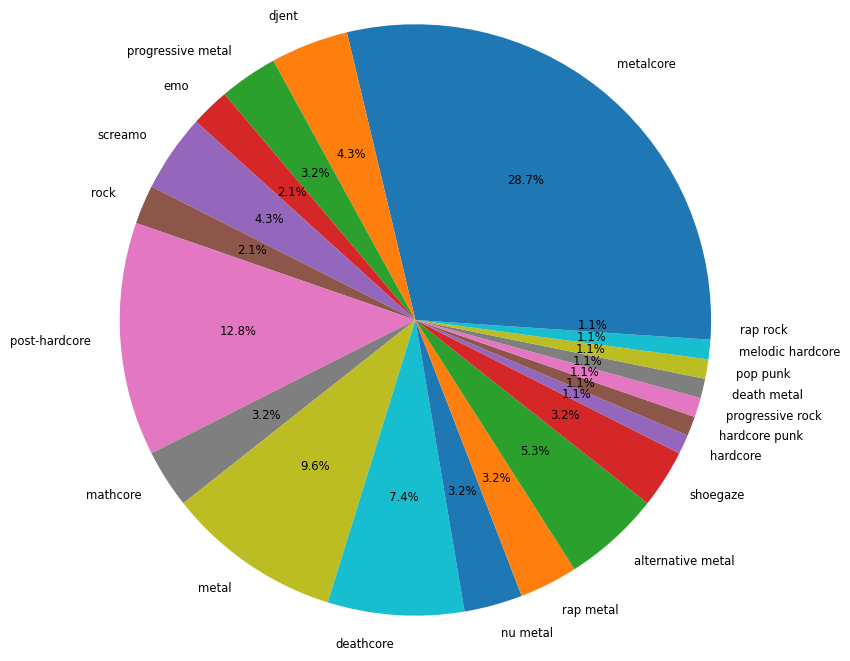

In [122]:
genres = [genre.strip() for ls in features_over1["genres"] for genre in ls]
genre_counts = Counter(genres)

labels = genre_counts.keys()
sizes = genre_counts.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', 
       radius=2, textprops={'size': 'smaller'})
plt.show()

### Step 4 - Pull Tour Information from Ticketmaster Discovery API
* I would like to be able to highlight or tag artists as being on tour or having announced a tour (preferably in the US). Note that being on tour is separate from festivals.
* Note that there is an API restriction of 5000 requests per day - that should not be a problem, though. I don't imagine I'll need more than like a few hundred requests per day at max.
* Additionally, another means of grabbing "similar artists" would be to grab artists performing at the same event, i.e., openers or headliners (e.g., Loathe opened for Spiritbox, so I'd consider them similar artists of each other). I am not sure yet whether to apply this for festivals as well. There are a lot of performers at metal concerts (100+ bands at Aftershock, e.g.); 
  * For each event returned for an artist, go to `_embedded` > `attractions` to get the performers.
* Use the `events` endpoint for our purposes, and search by `keyword` (artist name). Filter for music.
  * Check that the artist is actually correct by looking into each event's `_embedded` > `attractions` > `name` or `id` (type should be attraction, not venue)
  * Save the IDs of all attractions (artists) returned on primary search.
  * From what I can tell, if it is a tour (and the queried artist is performing as either the headliner or an opener), the event title will contain "tour", or the artst name will be in the event title. Festivals are just the festival name, and festivals have their subType classification listed as "festival".
  * E.g., for Spiritbox's upcoming NA tour w/ Periphery:
 
```json
{'name': 'Spiritbox w/ Periphery',
 'type': 'event',
 'id': 'Z7r9jZ1A7bMrv',
 'test': False,
 'url': 'https://www.ticketmaster.com/event/Z7r9jZ1A7bMrv',
 'locale': 'en-us',
 'sales': {'public': {'startDateTime': '2025-07-11T17:00:00Z',
   'startTBD': False,
   'startTBA': False,
   'endDateTime': '2025-11-14T03:00:00Z'}},
 'dates': {'start': {'localDate': '2025-11-13',
   'localTime': '19:00:00',
   'dateTime': '2025-11-14T03:00:00Z',
   'dateTBD': False,
   'dateTBA': False,
   'timeTBA': False,
   'noSpecificTime': False},
  'status': {'code': 'offsale'},
  'spanMultipleDays': False},
 'classifications': [{'primary': True,
   'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
   'genre': {'id': 'KnvZfZ7vAvl', 'name': 'Other'},
   'subGenre': {'id': 'KZazBEonSMnZfZ7vk1I', 'name': 'Other'},
   'family': False}],
 'outlets': [{'url': 'http://www.palms.com/pearl-theater.html',
   'type': 'venueBoxOffice'},
  {'url': 'https://www.ticketmaster.com/spiritbox-w-periphery-las-vegas-nevada-11-13-2025/event/Z7r9jZ1A7bMrv',
   'type': 'tmMarketPlace'}],
 'seatmap': {'staticUrl': 'https://content.resale.ticketmaster.com/maps/5018-1-1-main.gif',
  'id': 'seatmap'},
 'ticketing': {'allInclusivePricing': {'enabled': True}, 'id': 'ticketing'},
 '_links': {'self': {'href': '/discovery/v2/events/Z7r9jZ1A7bMrv?locale=en-us'},
  'attractions': [{'href': '/discovery/v2/attractions/Z7r9jZa2iz?locale=en-us'},
   {'href': '/discovery/v2/attractions/K8vZ917u1I7?locale=en-us'},
   {'href': '/discovery/v2/attractions/K8vZ917QBeV?locale=en-us'}],
  'venues': [{'href': '/discovery/v2/venues/ZFr9jZkvea?locale=en-us'}]},
 '_embedded': {'venues': [{'name': 'Pearl Concert Theater at Palms Casino Resort',
    'type': 'venue',
    'id': 'ZFr9jZkvea',
    'test': False,
    'locale': 'en-us',
    'postalCode': '89103',
    'timezone': 'America/Los_Angeles',
    'city': {'name': 'Las Vegas'},
    'state': {'name': 'Nevada', 'stateCode': 'NV'},
    'country': {'name': 'United States Of America', 'countryCode': 'US'},
    'location': {'longitude': '-115.209503000', 'latitude': '36.112701000'},
    'dmas': [{'id': 319}],
    'upcomingEvents': {'tmr': 26,
     'ticketmaster': 27,
     '_total': 53,
     '_filtered': 0},
    '_links': {'self': {'href': '/discovery/v2/venues/ZFr9jZkvea?locale=en-us'}}}],
  'attractions': [{'name': 'Spiritbox',
    'type': 'attraction',
    'id': 'Z7r9jZa2iz',
    'test': False,
    'locale': 'en-us',
    'classifications': [{'primary': True,
      'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
      'genre': {'id': 'KnvZfZ7vAvl', 'name': 'Other'},
      'subGenre': {'id': 'KZazBEonSMnZfZ7vk1I', 'name': 'Other'},
      'family': False}],
    'upcomingEvents': {'tmr': 4,
     'ticketmaster': 15,
     '_total': 19,
     '_filtered': 0},
    '_links': {'self': {'href': '/discovery/v2/attractions/Z7r9jZa2iz?locale=en-us'}}},
   {'name': 'Periphery',
    'type': 'attraction',
    'id': 'K8vZ917u1I7',
    'test': False,
    'url': 'https://www.ticketmaster.com/periphery-tickets/artist/1498978',
    'locale': 'en-us',
    'externalLinks': {'youtube': [{'url': 'https://www.youtube.com/user/periphery'}],
     'twitter': [{'url': 'https://mobile.twitter.com/peripheryband'}],
     'itunes': [{'url': 'https://music.apple.com/us/artist/periphery/187683869'}],
     'lastfm': [{'url': 'http://www.last.fm/music/Periphery'}],
     'spotify': [{'url': 'https://open.spotify.com/artist/6d24kC5fxHFOSEAmjQPPhc'}],
     'wiki': [{'url': 'https://en.wikipedia.org/wiki/Periphery_(band)'}],
     'facebook': [{'url': 'https://www.facebook.com/PeripheryBand'}],
     'instagram': [{'url': 'https://www.instagram.com/periphery/'}],
     'musicbrainz': [{'id': 'a0cef17a-4574-44f4-9f97-fd068615dac6',
       'url': 'https://musicbrainz.org/artist/a0cef17a-4574-44f4-9f97-fd068615dac6'}],
     'homepage': [{'url': 'http://www.periphery.net'}]},
    'classifications': [{'primary': True,
      'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
      'genre': {'id': 'KnvZfZ7vAeA', 'name': 'Rock'},
      'subGenre': {'id': 'KZazBEonSMnZfZ7v6dt', 'name': 'Alternative Rock'},
      'type': {'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'},
      'subType': {'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'},
      'family': False}],
    'upcomingEvents': {'tmr': 4,
     'ticketmaster': 15,
     '_total': 19,
     '_filtered': 0},
    '_links': {'self': {'href': '/discovery/v2/attractions/K8vZ917u1I7?locale=en-us'}}},
   {'name': 'Honey Revenge',
    'type': 'attraction',
    'id': 'K8vZ917QBeV',
    'test': False,
    'url': 'https://www.ticketmaster.com/honey-revenge-tickets/artist/2952536',
    'locale': 'en-us',
    'classifications': [{'primary': True,
      'segment': {'id': 'KZFzniwnSyZfZ7v7nJ', 'name': 'Music'},
      'genre': {'id': 'KnvZfZ7vAeA', 'name': 'Rock'},
      'subGenre': {'id': 'KZazBEonSMnZfZ7v6dt', 'name': 'Alternative Rock'},
      'type': {'id': 'KZAyXgnZfZ7v7l1', 'name': 'Group'},
      'subType': {'id': 'KZFzBErXgnZfZ7vA71', 'name': 'Band'},
      'family': False}],
    'upcomingEvents': {'tmr': 4,
     'ticketmaster': 14,
     '_total': 18,
     '_filtered': 0},
    '_links': {'self': {'href': '/discovery/v2/attractions/K8vZ917QBeV?locale=en-us'}}}]}}
```

* So ultimately, the information I should be retrieving from the Discovery API are:
  * Tour status for list of artists (from playlist, lastfm recommendations, and previous iterations of tour performers)
  * Artists touring with the queried artists, and whether that relationship was a tour or festival relationship (or both)
 
Subtasks: 
1. Identification of artist tour status (set the sort to date,name,asc) as either:
   * currently on tour
     * if multiple upcoming events have "tour" in their name or their subtype is not festival
   * has an upcoming tour
     * same as above (not sure if there is a good way to distinguish it)
   * not on tour
     * above is not fulfilled
2. Identification of artists touring with the queried artist. Can be done for both tour shows and festivals; presumably tour associations are more "significant" than festival ones (?) and can be weighted as so.
   * From what I can tell, I cannot obtain event information prior to the current date, so I can only grab artist associations that are currently or soon to occur. That's a bit of a limitation, seeing as evidently prior associations matter as well. Also, if a tour is occurring or impending, those artist associations will go away after the tour ends, and then that information will no longer be retrievable. So I wonder if there is some way of storing the associations somehow and build it up over time instead of only retrieving what is current.
   * Also, I don't know what a good amount of events to retrieve is. Ideally all of them, I suppose, but that may be quite time consuming. Parallelizing would hopefully be useful. I don't imagine many if any artists at all will have more than a single page of events (max 199 or 200 events) so probably there isn't any need to even paginate. Just grab the max events off of the first page.
   * For each event, go into `attractions` and grab the artists associated with the event (make sure their type is "attraction" and not "venue". Depends on how the information is recorded but if a bunch of events have the same name, it is likely that the attractions will be the same (e.g. the openers stay the same across a tour), although they may differ for specific shows. I'm not sure if that is recorded a certain way. But it would save time to not have to iterate through every show of a tour. Ultimately return a list of artists associated with the queried artist, as well as the specific association (toured with, played festival with). I do still want to retain the connections between artists even if the connected artist is already in the initial starting playlist; I want to be able to visualize that in the KG. It's just that when making recommendations, such artists would not be considered.

In [125]:
TICKETMASTER_API_KEY = os.environ.get("TM_API_KEY")

In [130]:
# TODO: not all returned events may be correctly associated w the artist as we are searching by keyword
# We can filter by name or ID in the list of attractions for each event, it would just be inefficient, and would
# also require grabbing artist (attraction) IDs via a diff API call if names are ambiguous
def get_artist_events(artist_name, api_key=TICKETMASTER_API_KEY):

    """Returns a list of events associated with a provided artist name. Max 200."""

    artist_name_formatted = "+".join(artist_name.split()).lower()
    url = f"https://app.ticketmaster.com/discovery/v2/events.json?apikey={api_key}&classificationName=music&keyword={artist_name_formatted}&sort=date,name,asc&size=200"
    response = requests.get(url).json()

    # if artist was found
    if "_embedded" in response.keys():
        
        return response["_embedded"]["events"]

    return None

In [131]:
thornhill_events = get_artist_events("Thornhill")
thornhill_events

[{'name': 'LANDMVRKS "NORTH AMERICA 2025" TOUR',
  'type': 'event',
  'id': '17G8vxG616e4AVA',
  'test': False,
  'url': 'https://www.ticketmaster.ca/landmvrks-north-america-2025-tour-montreal-quebec-09-14-2025/event/310062A1C2545D05',
  'locale': 'en-us',
  'images': [{'ratio': '3_2',
    'url': 'https://s1.ticketm.net/dam/a/495/de849747-b149-4906-bff5-4458a1fec495_ARTIST_PAGE_3_2.jpg',
    'width': 305,
    'height': 203,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/495/de849747-b149-4906-bff5-4458a1fec495_RETINA_LANDSCAPE_16_9.jpg',
    'width': 1136,
    'height': 639,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/495/de849747-b149-4906-bff5-4458a1fec495_TABLET_LANDSCAPE_16_9.jpg',
    'width': 1024,
    'height': 576,
    'fallback': False},
   {'ratio': '4_3',
    'url': 'https://s1.ticketm.net/dam/a/495/de849747-b149-4906-bff5-4458a1fec495_CUSTOM.jpg',
    'width': 305,
    'height': 225,
    'fallb

In [163]:
omens_events = get_artist_events("Bad Omens")
omens_events

[{'name': 'Louder Than Life',
  'type': 'event',
  'id': '1ApZkASGkexQ0qw',
  'test': False,
  'url': 'https://on.fgtix.com/trk/VEe0b',
  'locale': 'en-us',
  'images': [{'ratio': '3_2',
    'url': 'https://s1.ticketm.net/dam/a/a08/9909316c-8e80-435c-a648-c4de964c3a08_TABLET_LANDSCAPE_3_2.jpg',
    'width': 1024,
    'height': 683,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/a08/9909316c-8e80-435c-a648-c4de964c3a08_RETINA_PORTRAIT_16_9.jpg',
    'width': 640,
    'height': 360,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/a08/9909316c-8e80-435c-a648-c4de964c3a08_TABLET_LANDSCAPE_16_9.jpg',
    'width': 1024,
    'height': 576,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/a08/9909316c-8e80-435c-a648-c4de964c3a08_RETINA_LANDSCAPE_16_9.jpg',
    'width': 1136,
    'height': 639,
    'fallback': False},
   {'ratio': '16_9',
    'url': 'https://s1.ticketm.net/dam/a/a08

In [160]:
def is_tour(event_info): 

    """Infers whether a specific event is part of an artist tour or a festival."""

    classifications = event_info.get("classifications", [])

    for c in classifications: 

        if c.get("subType", {}).get("name") == "Festival": 
            return False
            
    # if there are more than 5 performers, it's probably a festival 
    # the most openers I've ever heard of for a tour is 3, 4 incl. the headliner
    if len(event_info.get("_embedded", {}).get("attractions", [])) > 5: 
        return False

    return True

In [219]:
def get_artist_coperformers(artist_events):

    """Returns lists of tour and festival coperformers, and determines whether or not an artist 
       is currently on tour, about to start tour, or not on tour."""

    tour_status = "not_touring" 
    tour_date = None
    current_date = datetime.now()
    # if a tour is 30+ days in the future, it is an upcoming tour
    # any less than that and it is considered a current tour 
    future_threshold = current_date + timedelta(days=30)
    # not specifying the event at which they were coperformers as the event titles are inconsistent
    tour_coperformers = []
    festival_coperformers = []

    # group names (if the artist is touring, these tend to be the same, but not always)
    event_groups = {}
    for event in artist_events: 
        event_name = event.get("name", "").lower()
        event_name = event_name.translate(str.maketrans('', '', string.punctuation))
        event_groups.setdefault(event_name, []).append(event)

    for event_name, events_info in event_groups.items(): 

        event_is_tour = is_tour(events_info[0])
        
        # grab coperformers for each event (assuming that each event w the same title has the same attractions)
        event_attractions = events_info[0].get("_embedded", {}).get("attractions", [])
        # names of coperformers for this event
        event_attractions = [adict["name"] for adict in event_attractions if is_tour(adict)]
       
        if event_is_tour: 
            tour_coperformers += event_attractions
            if tour_date == None: 
                event_date_str = events_info[0]["dates"]["start"]["localDate"]
                tour_date = datetime.strptime(event_date_str, "%Y-%m-%d")
        else:
            festival_coperformers += event_attractions

    # determine specific tour status
    if tour_date: 
        if tour_date >= future_threshold: 
            tour_status = "upcoming_tour"
        elif current_date <= tour_date <= future_threshold:
            tour_status = "on_tour"

    # TODO: note that both coperformer sets will include the original artist
    return tour_status, tour_date, set(tour_coperformers), Counter(festival_coperformers)

In [220]:
tour_status, tour_date, tours, festivals = get_artist_coperformers(omens_events)
tour_status, tour_date

('not_touring', None)

In [221]:
festivals

Counter({'Slayer': 1,
         'Avenged Sevenfold': 1,
         'Deftones': 2,
         'Lamb of God': 2,
         'Breaking Benjamin': 1,
         'A Perfect Circle': 2,
         'Evanescence': 1,
         'Down': 1,
         'Mudvayne': 2,
         'Stone Temple Pilots': 1,
         'Knocked Loose': 2,
         'Cavalera': 1,
         'Insane Clown Posse': 1,
         'Acid Bath': 2,
         'Slaughter To Prevail': 2,
         'Carcass': 2,
         'Municipal Waste': 1,
         'Winds of Plague': 2,
         'Static-X': 2,
         'Dope': 2,
         'Nonpoint': 2,
         'Failure': 2,
         'Superheaven': 1,
         'quannnic': 2,
         'Bilmuri': 2,
         'Memphis May Fire': 2,
         'Escape the Fate': 1,
         'Rob Zombie': 2,
         'Sleep Token': 1,
         'Bad Omens': 2,
         '$UICIDEBOY$': 1,
         'Marilyn Manson': 2,
         'Spiritbox': 1,
         'I Prevail': 1,
         'Three Days Grace': 2,
         'Cannibal Corpse': 1,
         'Days

In [222]:
tour_status, tour_date, tours, festivals = get_artist_coperformers(thornhill_events)

In [223]:
tour_status, tour_date

('upcoming_tour', datetime.datetime(2025, 9, 14, 0, 0))

In [224]:
tours

{'Bloom', 'Landmvrks', 'Ocean Grove', 'Resolve', 'Silly Goose', 'Thornhill'}

### Step 4 - Grab similar artists using Lastfm API.
* In the final UI, I want to be able to toggle how many ripples outwards to go. Start with just one though; that would also be the ripple that contains the most immediate artists I should look into as they are deemed most similar to the ones I already like.

In [227]:
LASTFM_API_KEY = os.environ.get("LASTFM_API_KEY")

In [233]:
def get_similar_artists(artist_name, api_key=LASTFM_API_KEY):

    """Returns similar artists to a given artist, alongside similarity score (from Lastfm)"""

    artist_name_formatted = "+".join(artist_name.split()).lower()
    url = f"https://ws.audioscrobbler.com/2.0/?method=artist.getsimilar&artist={artist_name_formatted}&api_key={api_key}&format=json"
    response = requests.get(url).json().get("similarartists", {}).get("artist", [])

    return response

In [232]:
thornhill_similar = get_similar_artists("thornhill")
thornhill_similar

[{'name': 'Invent Animate',
  'match': '1',
  'url': 'https://www.last.fm/music/Invent+Animate',
  'image': [{'#text': 'https://lastfm.freetls.fastly.net/i/u/34s/2a96cbd8b46e442fc41c2b86b821562f.png',
    'size': 'small'},
   {'#text': 'https://lastfm.freetls.fastly.net/i/u/64s/2a96cbd8b46e442fc41c2b86b821562f.png',
    'size': 'medium'},
   {'#text': 'https://lastfm.freetls.fastly.net/i/u/174s/2a96cbd8b46e442fc41c2b86b821562f.png',
    'size': 'large'},
   {'#text': 'https://lastfm.freetls.fastly.net/i/u/300x300/2a96cbd8b46e442fc41c2b86b821562f.png',
    'size': 'extralarge'},
   {'#text': 'https://lastfm.freetls.fastly.net/i/u/300x300/2a96cbd8b46e442fc41c2b86b821562f.png',
    'size': 'mega'},
   {'#text': 'https://lastfm.freetls.fastly.net/i/u/300x300/2a96cbd8b46e442fc41c2b86b821562f.png',
    'size': ''}],
  'streamable': '0'},
 {'name': 'Northlane',
  'mbid': 'f4e44995-1890-42a0-a6c1-9185b71655fa',
  'match': '0.994020',
  'url': 'https://www.last.fm/music/Northlane',
  'image': [

### Feature Consolidation

In [239]:
def get_spotify_artist_by_search(artist_name, client=SPOTIFY):

    return client.search(q=artist_name, type="artist").get("artists", {}).get("items", [])[0]

In [240]:
thornhill = get_spotify_artist_by_search("Thornhill")
thornhill

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2dE5audbkV3o5cKxvM7lBD'},
 'followers': {'href': None, 'total': 162133},
 'genres': ['metalcore', 'djent'],
 'href': 'https://api.spotify.com/v1/artists/2dE5audbkV3o5cKxvM7lBD',
 'id': '2dE5audbkV3o5cKxvM7lBD',
 'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb1b292d70780f166fd776b295',
   'height': 640,
   'width': 640},
  {'url': 'https://i.scdn.co/image/ab676161000051741b292d70780f166fd776b295',
   'height': 320,
   'width': 320},
  {'url': 'https://i.scdn.co/image/ab6761610000f1781b292d70780f166fd776b295',
   'height': 160,
   'width': 160}],
 'name': 'Thornhill',
 'popularity': 57,
 'type': 'artist',
 'uri': 'spotify:artist:2dE5audbkV3o5cKxvM7lBD'}